Investigating predictions from initial model on a single image from validation set

In [1]:
cd ..

C:\Users\macle\Dropbox\mcode\SerpentAI


In [2]:
from plugins.SerpentMiniMetroGamePlugin.files.api.object_detector import ObjectDetector, draw_bounding_box, rgb2gray3d
import tensorflow as tf
import skimage.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from matplotlib import patches, patheffects
from itertools import islice

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
frozen_graph_path = "plugins/SerpentMiniMetroGamePlugin/files/ml_models/station_detector_m0_frozen_graph.pb"
labels_path = "plugins/SerpentMiniMetroGamePlugin/files/ml_models/station_detector_m0_label_map.json"

In [4]:
station_detector = ObjectDetector(frozen_graph_path, labels_path)

In [5]:
test_image = skimage.io.imread("../../ml_train/station_detector/data/test/frame_1534972364.5022948.png")

Plotting predictions for test image

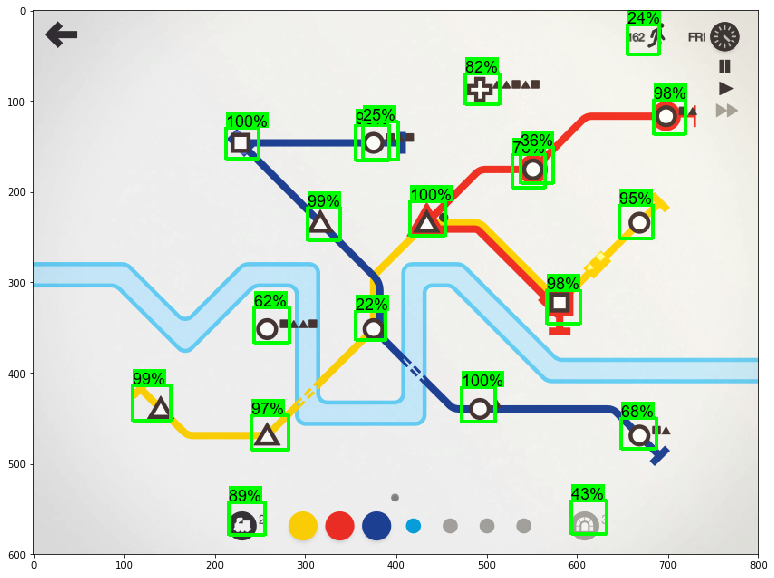

In [6]:
_, ax = plt.subplots(figsize=(15,10))

test_results = station_detector.run_inference(test_image)

ax.imshow(station_detector.draw_bounding_boxes(test_image, **test_results))

#### Investigation

Getting input tensor to populate with test image

In [7]:
sess = tf.InteractiveSession(graph=station_detector.graph)

test_image = test_image[np.newaxis,...]
image_tensor = tf.get_default_graph().get_tensor_by_name("image_tensor:0")

In [8]:
def grid_plot(array_3d, figwidth=15, figheight=None, mincols=2, maxcols=15, vmin=None, vmax=None):
    """Split 3d array on axis=2 and plot grid of 2d arrays """
    
    assert array_3d.ndim == 3
    
    height, width, channels = array_3d.shape
    aspect_ratio = height / width
    
    # set number of columns / rows in grid
    ncols = np.clip(int((figwidth ** 2.6) // width), mincols, maxcols) # chosen to give good default resolution across different input sizes
    nrows = 1 + channels // ncols 
    
    # caclulate sensible figsize if figheight not defined
    figsize = (figwidth, figwidth / ncols * nrows * aspect_ratio) if figheight is None else (figwidth, figheight)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=figsize)
    
    for i, ax in enumerate(axes.flat):
        if i < channels:
            ax.imshow(array_3d[...,i], cmap='gray', vmin=vmin, vmax=vmax)
            # hide axis labels/ticks
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        else:
            # remove unused axes
            fig.delaxes(ax)
    
    return fig

Pre-trained mobilenet provides weights for base network feature maps, default config for SSD object dection re-trains **two** existing layers and adds **four** new layers with decreasing resolution as feature maps for classification/localization.

Plotting samples of activations from depth slices from each of the six newly trained feature maps below.

In [9]:
feature_map_tensor_names = [
    "FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_11_pointwise/Relu6:0",
    "FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_pointwise/Relu6:0",
    "FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_2_3x3_s2_512/Relu6:0",
    "FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_3_3x3_s2_256/Relu6:0",
    "FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_4_3x3_s2_256/Relu6:0",
    "FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_5_3x3_s2_128/Relu6:0"
]

FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_11_pointwise/Relu6:0 (1, 19, 19, 512)


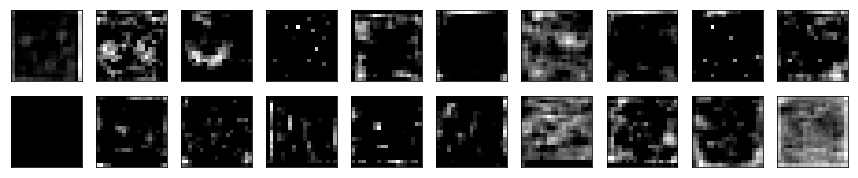

FeatureExtractor/MobilenetV1/MobilenetV1/Conv2d_13_pointwise/Relu6:0 (1, 10, 10, 1024)


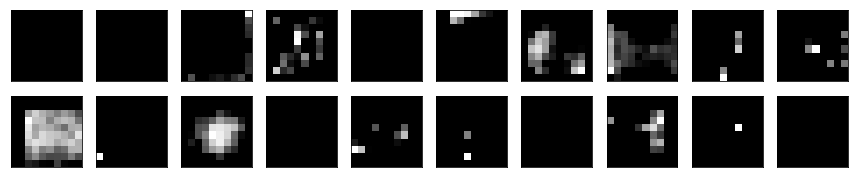

FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_2_3x3_s2_512/Relu6:0 (1, 5, 5, 512)


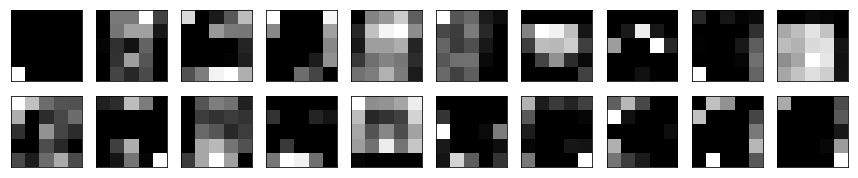

FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_3_3x3_s2_256/Relu6:0 (1, 3, 3, 256)


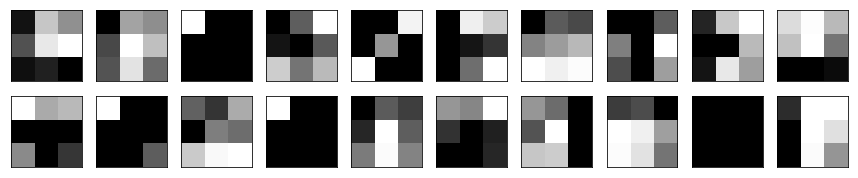

FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_4_3x3_s2_256/Relu6:0 (1, 2, 2, 256)


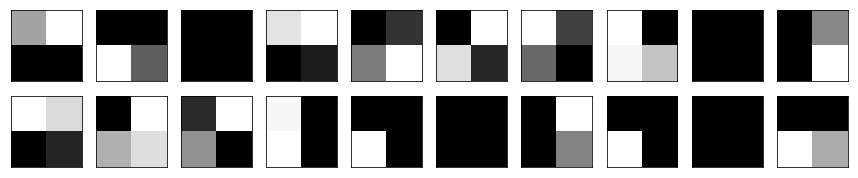

FeatureExtractor/MobilenetV1/Conv2d_13_pointwise_2_Conv2d_5_3x3_s2_128/Relu6:0 (1, 1, 1, 128)


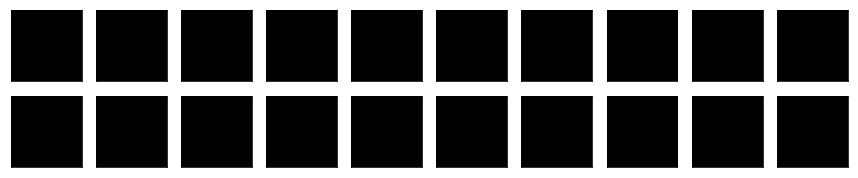

In [10]:
for tensor_name in feature_map_tensor_names:
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)
    output = sess.run(tensor, feed_dict={image_tensor: test_image})
    print(tensor_name, output.shape)
    grid_plot(output.squeeze(0)[...,:20], maxcols=10)
    plt.show();

Plotting examples of activations in object classification final layer. 1x1xn filters are convolved with respective feature maps above to produce these output.

x and y dimensions reflect shape of final feature map with each pixel (neuron) associated with a single "anchor box" location. Each level in z is corresponds to the activations for a combination of object class and anchor box shape.

In the highest layer there is an internal restriction set on the number of anchor box shapes (3) and so we get depth 6 corresponding to 2 classes (station or backgroung) and 3 shapes. The lower layers have 5 anchor box shapes plus an "additional" anchor with shape aspect 1.0 which is interpolated between the size of that layer and the next lowest layer. This gives us 2 (classes) x 6 anchors = depth of 12.

In [11]:
final_layer_tensor_names = [
    "BoxPredictor_0/ClassPredictor/Conv2D:0",
    "BoxPredictor_1/ClassPredictor/Conv2D:0",
    "BoxPredictor_2/ClassPredictor/Conv2D:0",
    "BoxPredictor_3/ClassPredictor/Conv2D:0",
    "BoxPredictor_4/ClassPredictor/Conv2D:0",
    "BoxPredictor_5/ClassPredictor/Conv2D:0",
]

BoxPredictor_0/ClassPredictor/Conv2D:0 (1, 19, 19, 6)


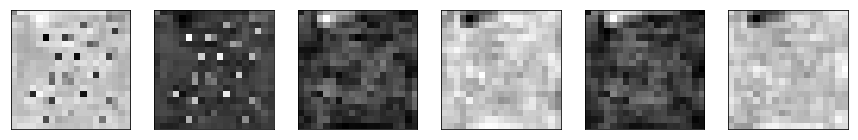

BoxPredictor_1/ClassPredictor/Conv2D:0 (1, 10, 10, 12)


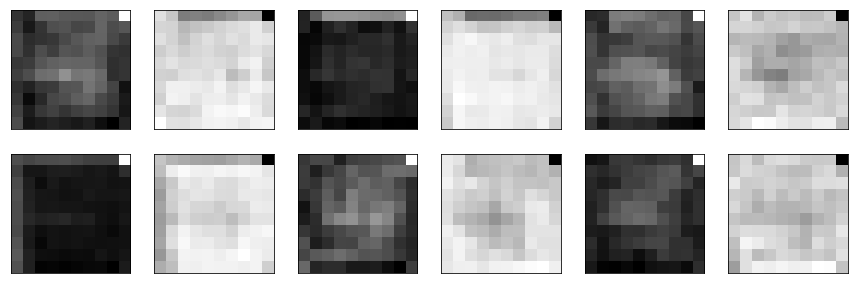

BoxPredictor_2/ClassPredictor/Conv2D:0 (1, 5, 5, 12)


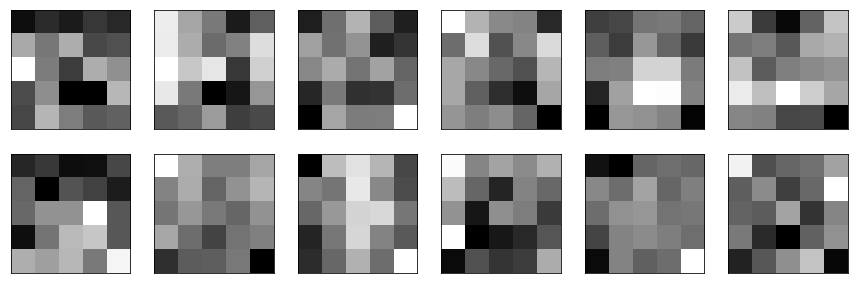

BoxPredictor_3/ClassPredictor/Conv2D:0 (1, 3, 3, 12)


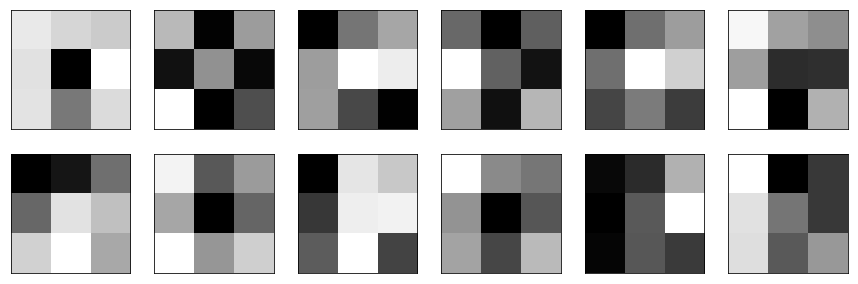

BoxPredictor_4/ClassPredictor/Conv2D:0 (1, 2, 2, 12)


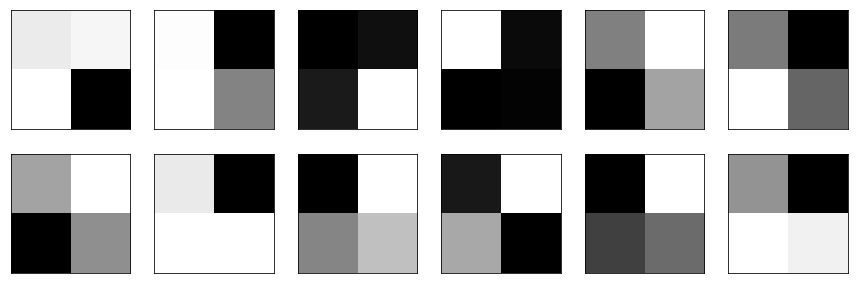

BoxPredictor_5/ClassPredictor/Conv2D:0 (1, 1, 1, 12)


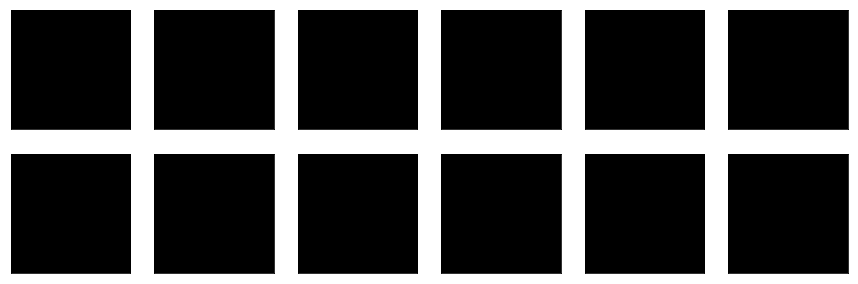

In [12]:
for tensor_name in final_layer_tensor_names:
    output = sess.run(tf.get_default_graph().get_tensor_by_name(tensor_name), feed_dict={image_tensor: test_image})
    print(tensor_name, output.shape)
    grid_plot(output.squeeze(0), maxcols=6)
    plt.show()

Activations are then passed through a sigmoid function to get final class probabilities, in the graph they are reshaped first but we will do it directly on these outputs as the preserved shape makes the activation locations more intuitive.

We will also set the color scale to be fixed [0,1] across all plots to make the activation magnitudes balanced

BoxPredictor_0/ClassPredictor/Conv2D:0 (1, 19, 19, 6)


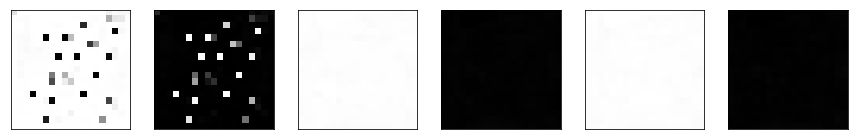

BoxPredictor_1/ClassPredictor/Conv2D:0 (1, 10, 10, 12)


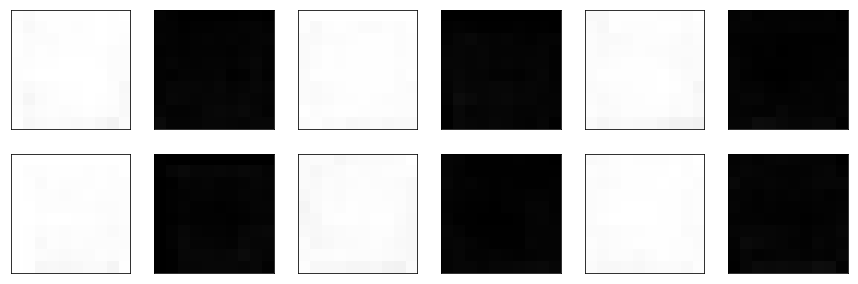

BoxPredictor_2/ClassPredictor/Conv2D:0 (1, 5, 5, 12)


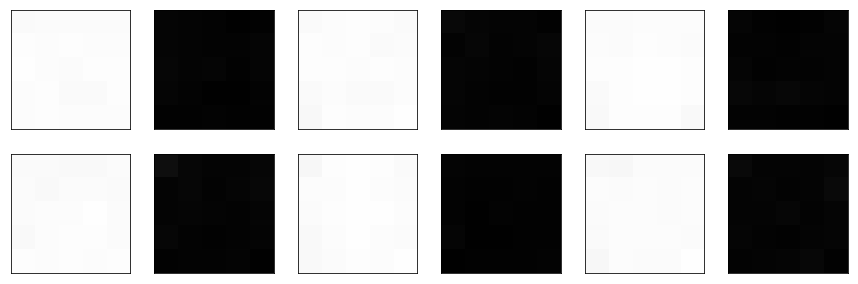

BoxPredictor_3/ClassPredictor/Conv2D:0 (1, 3, 3, 12)


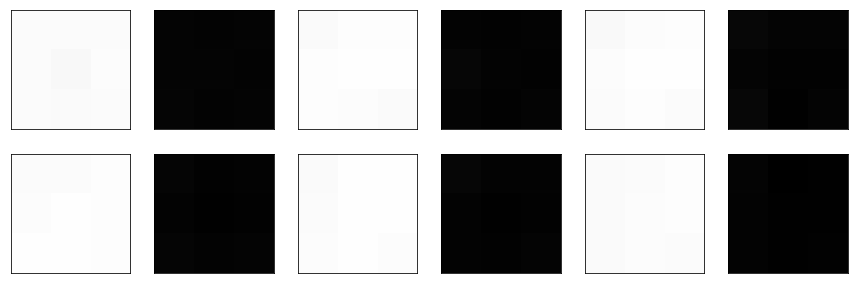

BoxPredictor_4/ClassPredictor/Conv2D:0 (1, 2, 2, 12)


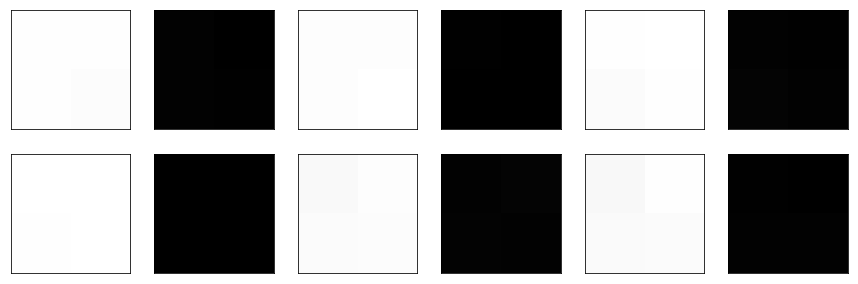

BoxPredictor_5/ClassPredictor/Conv2D:0 (1, 1, 1, 12)


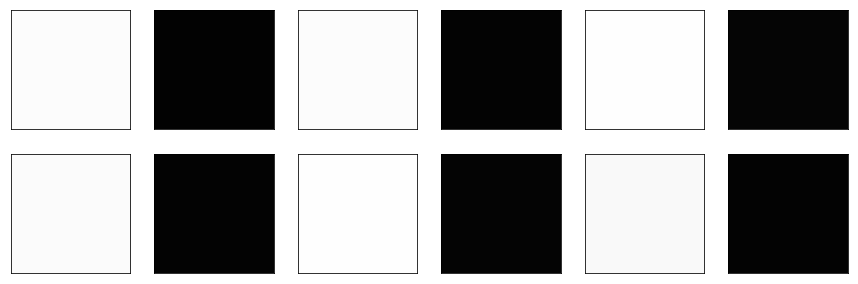

In [14]:
for tensor_name in final_layer_tensor_names:
    class_sigmoid = tf.sigmoid(tf.get_default_graph().get_tensor_by_name(tensor_name))
    output = sess.run(class_sigmoid, feed_dict={image_tensor: test_image})
    print(tensor_name, output.shape)
    grid_plot(output.squeeze(0), maxcols=6, vmin=0, vmax=1)
    plt.show()

In [15]:
class_sigmoid = tf.sigmoid(tf.get_default_graph().get_tensor_by_name("BoxPredictor_0/ClassPredictor/Conv2D:0"))
class_activations = sess.run(class_sigmoid, feed_dict={image_tensor: test_image}).squeeze()[...,1]

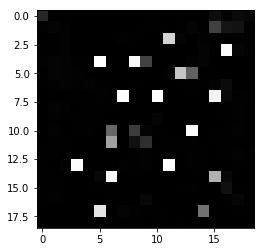

In [16]:
plt.imshow(class_activations, cmap='gray')

It is clear that only one (pair) of filters is affecting the result at all, it is the highest resolution feature map with the 1.0 aspect ratio anchor boxes. This matches intuition as our targets all require square bounding boxes and are relatively small.

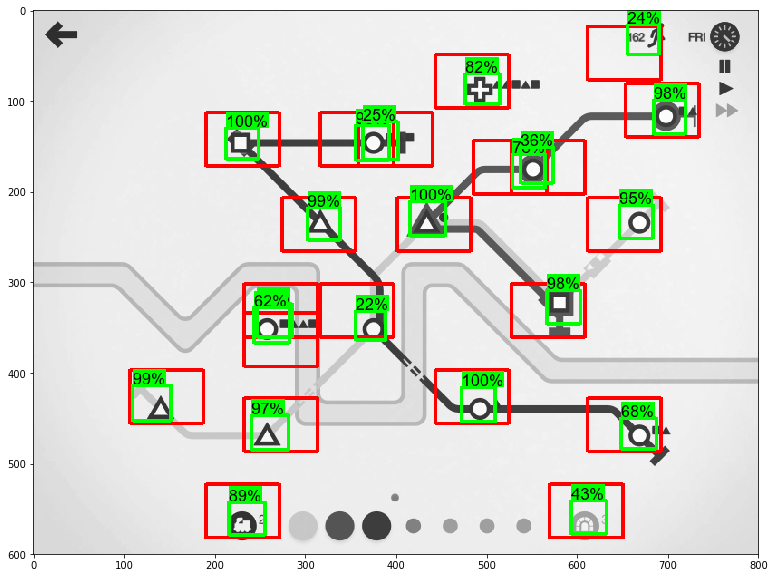

In [17]:
# getting all default (anchor) boxes
default_boxes = sess.run(tf.get_default_graph().get_tensor_by_name("Concatenate/concat:0"), feed_dict={image_tensor: test_image}).squeeze()
# getting ALL predicted boxes
boxes = sess.run(tf.get_default_graph().get_tensor_by_name("Postprocessor/Reshape_2:0"), feed_dict={image_tensor: test_image}).squeeze()

# getting class probability scores
raw_scores = tf.sigmoid(tf.get_default_graph().get_tensor_by_name("concat_1:0"))
scores = sess.run(raw_scores, feed_dict={image_tensor: test_image}).squeeze()[:,1]

# restrict index to boxes/scores which sit below threshold
threshold = 0.2
top_scores_indices = scores >= threshold
boxes = boxes[top_scores_indices]
default_boxes = default_boxes[top_scores_indices]
scores = scores[top_scores_indices]

# convert image to grayscale
test_image_gray = rgb2gray3d(test_image.squeeze())

for default_box in default_boxes:
    test_image_gray = draw_bounding_box(test_image_gray, *default_box, color='red')
    
for box, score in zip(boxes, scores):
    test_image_gray = draw_bounding_box(test_image_gray, *box, label='{:.0%}'.format(score))

_, ax = plt.subplots(figsize=(15,10))

ax.imshow(test_image_gray)

Confirmation that all the default boxes are the same scale/aspect as we discovered previously. Will try re-running model with only default boxes of this spec provided as anchors to see if we can improve training time / model size by reducing the number of weights we have to learn.

Also note that despite these boxes referring to an aspect of 1.0 the boxes are not actually square when plotted on our input image. This is because the input is compressed to be 300x300 and the default boxes are square at that resolution/shape.